## TP1 Reinforcement Learning

## 1 Dynamic Programming

The following simple example illustrates the basic components of a Markov Decision Process (MDP) with stationary reward and transition model. Fig. 1 illustrates a simple three-state MDP. The elements in braces denote the rewards, while the weights on the arcs are the transition probabilities. For example, action a0 in s0 is such that
$$p(s0|s0, a0) = 0.4, p(s1|s0, a0) = 0.6$$
And $$r(s0, a0) = 0$$

Assume a discount factor $γ = 0.95$

**• Q1: Implement the discrete MDP model. In this simple MDP it is simple to guess the optimal policy π∗. What is it?**

The optimal policy maximizes a fraction $\gamma^t$ of the reward in expectation. Therefore, we want to reach $s_2$ and remaining there doing in loop the action $a_2$. The shortest stochastic path to $s_2$ is to do $a_1$ in $s_0$ and $s_1$. This means that the optimal policy is π0 = [a1, a1, a2].

In [1]:
import numpy as np 

transitions = np.array([[[0.55, 0.3, 1],
                         [0.45, 0.7, 0],
                         [0, 0, 0]],
                        [[1, 0, 0],
                         [0, 0.4, 1],
                         [0, 0.6, 0]],
                        [[0, 0, 0],
                         [1, 0.6, 0],
                         [0, 0.4, 1]]
                       ], dtype=float)
#transitions(s1, s2, a0) = p(s1 | s2, a0)
gamma = 0.95 

rewards = np.array([[0, 0, 0.05],
                    [0, 0, 0],
                    [0, 1, 0.9]], dtype=float)


**Q2: Implement and run value iteration (VI) in order to identify a 0.01–optimal policy. Recall that the stopping criterion (theory slides) is to stop when
$$∥v^{k+1} − v^k∥_∞ < ε$$
which implies that [Puterman, 1994, Th. 6.3.1]
$$∥v^{π^+_{k+1}} −v_∗∥< \frac{2εγ}{1−γ}$$
Plot $∥v_k −v_∗∥_∞$ as a function of iteration k. Implement policy evaluation to compute $v_∗$, i.e. the value
function of the optimal policy.**


In [2]:
import matplotlib.pyplot as plt

n_states, n_actions = rewards.shape
old_value = np.zeros(n_states)
value = np.zeros(n_states)
values = []
eps = 1e-2
error = eps + 1
max_iter = 1000
n = 0

while error >= eps and n < max_iter:

    for s in range(n_states):
        all_values = np.zeros(n_actions)
        for a in range(n_actions):
#             print(f"n={n}, s={s}, a={a}, pv={rewards[s].dot(transitions[:,s, a]):.2f}, r={rewards[s]}, t={transitions[:,s, a]}")
            all_values[a] = rewards[s, a] + gamma * transitions[s, :, a].dot(value)
        value[s] = np.max(all_values)
    error = np.max(value - old_value)
    values.append(value.copy())
    old_value = value.copy()
    n += 1


v_opt = value
errors = np.array(values) - np.tile(v_opt, (n, 1))
plt.plot(errors)
plt.ylabel("$∥v^k −v_∗∥$")
plt.xlabel("Step")
plt.show()

<Figure size 640x480 with 1 Axes>

**Q3: implement exact policy iteration (PI) with initial policy π0 = [a1, a1, a2]. Compare the speed of convergence w.r.t. VI and discuss the relative merits of the two approaches.**

The initial policy given is the optimal policy. So we initialize our algorithm with $π0 = [a0, a1, a2]$

[1. 1. 1.]
[-1.         -0.95       -2.48629032]
[-1.11022302e-16 -1.55983871e+01 -1.55137097e+01]
[-14.39115723   0.           0.        ]
[0. 0. 0.]


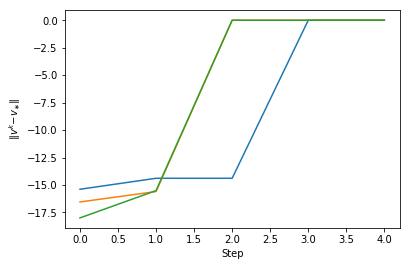

In [3]:
from numpy.linalg import inv

n_states, n_actions = rewards.shape
old_value = np.zeros(n_states)
v_pi = np.ones(n_states)
policy = np.zeros(n_states)
values = []
eps = 1e-2
error = eps + 1
max_iter = 20
n = 0

def _policy_evaluation(policy, t, r, gamma):
    n_states, n_actions = r.shape
    r_pi = np.array([r[x, int(policy[x])] for x in range(n_states)])
    p_pi = np.array([[t[x, y, int(policy[x])] for y in range(n_states)]  for x in range(n_states)])
    v_pi = inv(np.eye(n_states) - gamma*p_pi) @ r_pi
    return v_pi

def _policy_improvement(v_pi, t, r, gamma):
    n_states, n_actions = r.shape
    greedy = np.zeros(n_actions)
    policy = np.zeros(n_states)
    for x in range(n_states):
        for a in range(n_actions):
            greedy[a] = r[x, a] + gamma * t[x, :, a].dot(v_pi)
        policy[x] = np.argmax(greedy)
    return policy
    
def has_converged(v, old_v):
    return np.max(np.abs(v - old_v))
   
while has_converged(v_pi, old_value) and n < max_iter:
    old_value = v_pi.copy()
    v_pi = _policy_evaluation(policy, transitions, rewards, gamma)
    policy = _policy_improvement(v_pi, transitions, rewards, gamma)
    error = np.max(v_pi - old_value)
    values.append(v_pi.copy())
    print(old_value - v_pi)
    n += 1


v_opt = v_pi
errors = np.array(values) - np.tile(v_opt, (n, 1))
plt.plot(errors)
plt.ylabel("$∥v^k −v_∗∥$")
plt.xlabel("Step")
plt.show()

The convergence of policy iteration is much faster than for value iteration, but an iteration is more computationnally expensive.

The convergence of policy iteration is also exact, while it is asymptotic for value iteration

## 2. Reinforcement Learning



### 2.1 A Review of RL Agent/Environment Interaction

#### Policy evaluation. 

Consider the deterministic policy that is selecting the action right when available, otherwise up.

**Q4: denote with $V_n(x,a)$ the value function estimated using Monte-Carlo, i.e., empirical average:
$$V(s)= \frac{1}{N(s)}\sum_{k=1}^{N(s)}\sum_{t=1}^{T_{max}} \gamma^{t-1}r_t^{(k)}$$
with $s_1=s,a_t∼π(·|s_t)$
 where $\sum_s N(s) = n$ and $(r_t^{(k)})$
is the sequence of rewards obtained when simulating the k-th trajectory st
(using the simulator).
Build such estimator and plot $J_n − J^π$ as a function of n, where
$$V_π =[0.877,0.928,0.988,0,0.671,−0.994,0,−0.828,−0.877,−0.934,−0.994]T$$**

/Users/pierre-louis/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


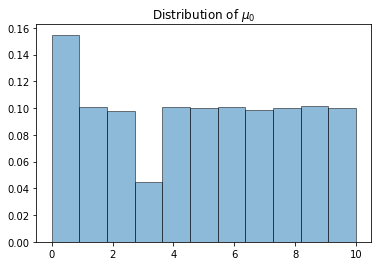

In [4]:
from gridworld import GridWorld1
env = GridWorld1

def evaluate_dist_mu(env, n_iter=50000):
    mu0 = [env.reset() for i in range(n_iter)]
    dist_mu, _ = np.histogram(mu0, bins=env.n_states)
    return mu0, dist_mu/n_iter

mu0, dist_mu = evaluate_dist_mu(env)
plt.figure()
plt.title("Distribution of $\mu_0$")
plt.hist(mu0, bins=env.n_states, normed=True, edgecolor='k', alpha=0.5)
plt.show()

In [80]:
def _mc_simulations(env, policy, N=500, t_max=100, **kwargs):
    """ Do a Monte Carlo simulations with N episodes. """
    all_actions = []
    all_rewards = []
    all_states = []

    for e in range(N):
        s = env.reset()
        t = 0
        term = False 
        reward_e = []
        state_e = []
        action_e = []
        while t < t_max and not term:
            a = policy(env.state_actions[s], s, **kwargs)
            s, r, term = env.step(s, a)
            reward_e.append(r)
            action_e.append(a)
            state_e.append(s)
            t += 1
        all_rewards.append(np.array(reward_e))
        all_states.append(np.array(state_e))
        all_actions.append(np.array(action_e))
        
    return all_rewards, all_states, all_actions

def _find_trajectories(s, all_states):
    trajectories = []
    for k, states in enumerate(all_states):
        if states[0] == s:
            trajectories.append(k)
    return trajectories 

def _discounted_reward(rewards, gamma=0.95):
    acc = 0.0
    for t in range(1, len(rewards)+1):
        acc += gamma**(t-1)*rewards[t-1]
    return acc

def mc_value(env, policy, N=500, gamma=0.95, t_max=100, **kwargs):
    """ 
    Estimate a value function from Monte-Carlo simulations for a given policy.
    The simulation is run for N trajectories. 
    Policy parameter is a callback function whose parameter is the set of actions
    """
    Vn = np.zeros(env.n_states)
    all_rewards, all_states, all_actions = _mc_simulations(env, policy, N, t_max=t_max, **kwargs)
    for s in range(env.n_states):
        trajectories = _find_trajectories(s, all_states)
        Ns = len(trajectories)
        if Ns == 0:
            continue
        acc = 0.0
        for k in range(Ns):
            states = all_states[k]
            rewards = all_rewards[k]
            actions = all_actions[k]
            acc += _discounted_reward(rewards, gamma)
        Vn[s] = acc/Ns
    return Vn

In [77]:
def ponderate_value(values, dist_mu):
    return values.dot(dist_mu)

def policy(actions, state):
    if 0 in actions: # turn right
        return 0
    return 3 # go up

_, dist_mu = evaluate_dist_mu(env)
n_values = 500
V = np.zeros((n_values, env.n_states))
J = np.zeros(n_values)
for n in range(n_values):
    V[n,:] = mc_value(env, policy, N=n+5)
    J[n] = ponderate_value(V[n], dist_mu)
    


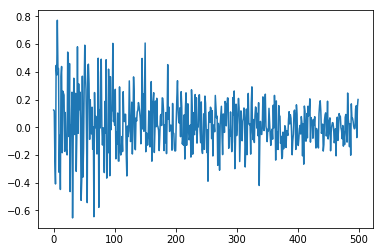

In [78]:
Vpi = np.array([0.877,0.928,0.988,0,0.671,-0.994,0,-0.828,-0.877,-0.934,-0.994])
Jpi = ponderate_value(Vpi, dist_mu)

plt.plot(J-Jpi)

In [8]:
dist_mu
print(Jpi)

-0.06243327999999998


### Question 5: Q_Learning

In [116]:
env = GridWorld1

def _action_update(Q, state, actions, eps=0.1):
    """ Compute the policy and return the action provided by the policy the given state.
    The action is thus defined as $argmax_a Q(x_t, a)$ with an $\epsilon$-greedy exploration policy."""
    
    action = actions[np.argmax(Q[state, actions])]
    
    # exploration algorithm
    if np.random.random() < eps and  actions != [action]:
        action = np.random.choice(list(set(actions) - set([action])))

    return action


def _alpha_update(N, state, action):
    return 1/N[state, action]

def _q_episode(Q, N, env, eps=0.1, gamma=0.95, t_max=1000):
    state = env.reset()
    t = 0
    term = False
    old_state = state
    n_actions = len(env.action_names)

    while t < t_max and not term:
        action = _action_update(Q, state, env.state_actions[state], eps=eps)
        N[state, action] +=1 
        alpha = _alpha_update(N, state, action)
        nexts, reward, term = env.step(state, action)
        Q[state, action] = (1-alpha)*Q[state, action] + alpha* \
                            (reward + gamma*np.max(Q[nexts]))
        t += 1
        state = nexts
    return Q, N

def _q_to_policy(Q):
    """ Return the optimal policy from Q"""
    return np.argmax(Q, axis=1)


def _q_to_value(Q):
    """ Return the estimated value function from Q """
    def policy(actions, state, pi=None):
        print(actions)
        print(state)
        print(pi[state])
        return pi[state]
    
    pi = q_to_policy(Q)
    print(pi)
    v = mc_value(env, policy, N=10, pi=pi)

    
def q_learning(env, gamma=0.95, n_iter=1000):
    """ Applies to Q Learning algorithm in ordeer to get the best policy """ 

    n = 0
    n_actions = len(env.action_names)
    Q = np.zeros((env.n_states, n_actions))
    N = np.zeros((env.n_states, n_actions))
    Qs = []
    while n < n_iter: #TODO add convergence criteria
        Q, N = _q_episode(Q, N, env, eps=0.1, t_max=1000, gamma=gamma)
        n += 1
        Qs.append(Q.copy())
    return Qs


qs = q_learning(env)
q = qs[-1]
print(q)

[[ 0.84874129  0.63751694  0.          0.        ]
 [ 0.92077674  0.          0.76255037  0.        ]
 [ 0.98737788  0.87027457  0.88475781  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.43530882  0.          0.74961382]
 [-0.8452122   0.77798631  0.          0.92110457]
 [ 0.          0.          0.          0.        ]
 [ 0.21163076  0.          0.          0.64731175]
 [ 0.63551851  0.          0.43853904  0.        ]
 [ 0.06390157  0.          0.44982465  0.84699278]
 [ 0.          0.          0.46226091 -0.84952298]]


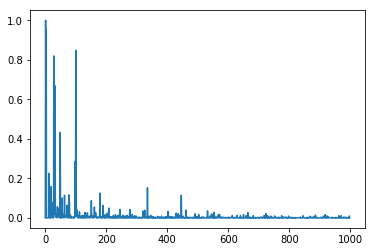

In [117]:
cv_q = []
for i in range(1, len(qs)):
    cv_q.append( np.max( qs[i] - qs[i-1]) )
plt.plot(cv_q)
plt.show()

In [92]:
pi = q_to_policy(q)
print(q)
print(pi)
print(len(pi))
print(env.state_actions)

[[ 0.89121875  0.81450625  0.          0.        ]
 [ 0.9036875   0.          0.83951302  0.        ]
 [ 1.          0.9025      0.81450625  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.75492003  0.          0.83647648]
 [-1.          0.857375    0.          0.95      ]
 [ 0.          0.          0.          0.        ]
 [ 0.78206218  0.          0.          0.79465266]
 [ 0.83688401  0.          0.75492003  0.        ]
 [ 0.81450625  0.          0.79017319  0.9025    ]
 [ 0.          0.          0.857375   -1.        ]]
[0 0 0 0 3 3 0 3 0 3 2]
11
[[0, 1], [0, 2], [0, 1, 2], [0], [1, 3], [0, 1, 3], [0], [0, 3], [0, 2], [0, 2, 3], [2, 3]]


In [ ]:
import gridrender
gridrender.render_q(env, q)